## Import libraries and data

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LogisticRegressionCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [89]:
fl = pd.read_csv('../Datasets/florida_1999_2020_unemp_claims.csv')
tx = pd.read_csv('../Datasets/texas_2010_2019_unemp_claims.csv')

In [90]:
fl.head()

,State,Filed week ended,Initial Claims,Reflecting Week Ended,Continued Claims,Covered Employment,Insured Unemployment Rate
0,Florida,1/2/99,"4,576",12/26/98,"71,429","6,342,395",1.13
1,Florida,1/9/99,"9,643",1/2/99,"68,393","6,394,163",1.07
2,Florida,1/16/99,"9,434",1/9/99,"71,774","6,394,163",1.12
3,Florida,1/23/99,"7,585",1/16/99,"70,196","6,394,163",1.10
4,Florida,1/30/99,"8,099",1/23/99,"73,250","6,394,163",1.15


In [91]:
fl.shape

(1101, 7)

### Make a datetime index to use as the time axis

In [92]:
fl.index = pd.DatetimeIndex(fl['Reflecting Week Ended'].values)
tx.index = pd.DatetimeIndex(tx['Reflecting Week Ended'].values)

### Turn claims columns to intigers

In [93]:
fl['Initial Claims'] = fl['Initial Claims'].str.replace(',', '')
fl['Continued Claims'] = fl['Continued Claims'].str.replace(',', '')

tx['Initial Claims'] = tx['Initial Claims'].str.replace(',', '')
tx['Continued Claims'] = tx['Continued Claims'].str.replace(',', '')

In [94]:
fl['Initial Claims'] = fl['Initial Claims'].astype(int)
fl['Continued Claims'] = fl['Continued Claims'].astype(int)

tx['Initial Claims'] = tx['Initial Claims'].astype(int)
tx['Continued Claims'] = tx['Continued Claims'].astype(int)

### Plot all claims since 1999 to look for spikes caused by hurricanes

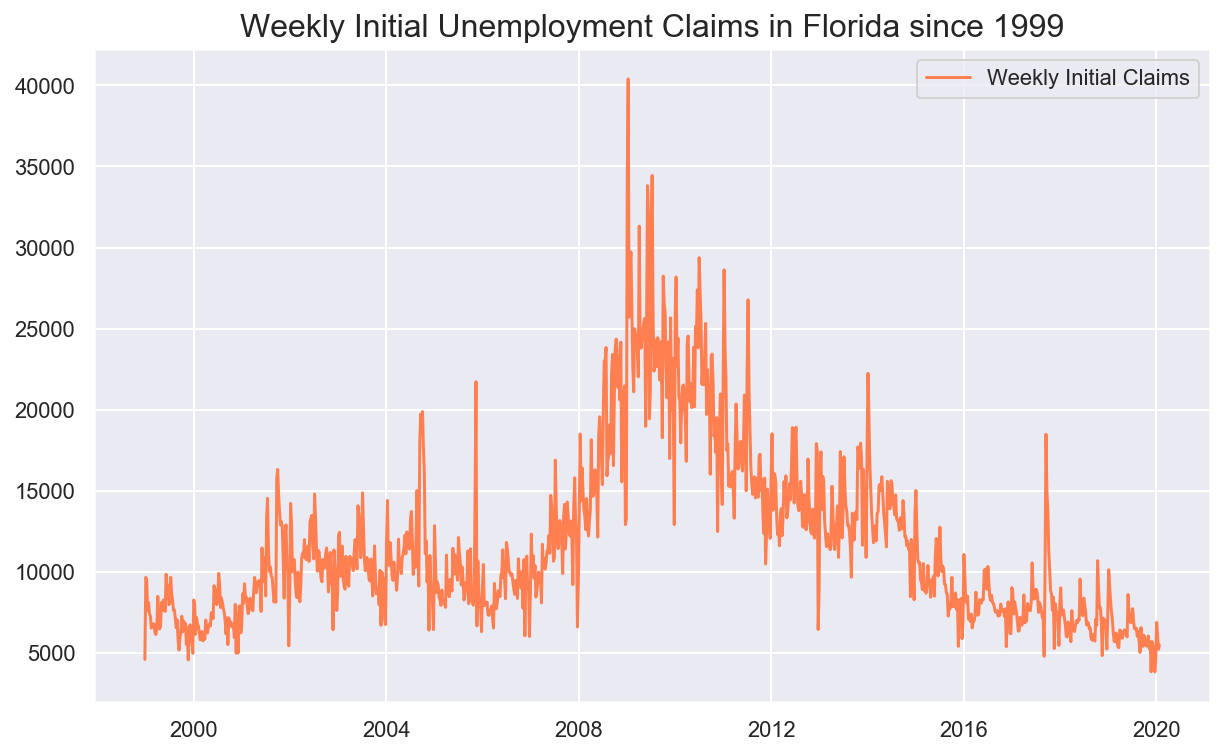

In [95]:
plt.figure(figsize=(10,6))
plt.title(label = 'Weekly Initial Unemployment Claims in Florida since 1999', fontsize=16);
sns.lineplot(data=fl['Initial Claims'], color="coral", label="Weekly Initial Claims");

### Apply an ARIMA model to the the data from 2016 to predict the claims during Irma

In [96]:
fl.index[-213]

Timestamp('2016-01-02 00:00:00')

In [97]:
# claim entry 5 weeks before the hurricane claim spike starts
#fl.index[-126]
fl.index[-131]

Timestamp('2017-07-29 00:00:00')

In [98]:
fl.index[-115]

Timestamp('2017-11-18 00:00:00')

In [99]:
# train_start_row = fl.shape[0] - 213
# train_stop_row = fl.shape[0] - 131
# test_stop_row = fl.shape[0] - 115

# train = fl.iloc[train_start_row:train_stop_row]
# test = fl.iloc[train_stop_row:test_stop_row]

In [100]:
train_start_row = fl.shape[0] - 213
train_stop_row = fl.shape[0] - 131
test_stop_row = fl.shape[0] - 115

train = fl.iloc[train_start_row:train_stop_row]
test = fl.iloc[train_stop_row:test_stop_row]

In [101]:
# # online example

# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
#     model = ARIMA(history, order=(4, 0, 2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)

# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()

In [102]:
train.shape

(82, 7)

In [103]:
test_stop_row

986

In [104]:
train_stop_row

970

In [105]:
arima = ARIMA(endog = train['Initial Claims'],
              order = (4, 0, 2),
              freq = 'W-SAT')

# Fit SARIMA model.
model = arima.fit()

# Generate predictions based on test set.
#preds = model.predict(start = (train.shape[0] - (test_stop_row-train_stop_row) + 1), end = train.shape[0])

# Evaluate predictions.
#print(mean_absolute_error(test['Initial Claims'], preds))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [106]:
preds = model.predict(start = (train.shape[0]), end = train.shape[0] + (test_stop_row-train_stop_row))


#### Plot Predictions

ValueError: arrays must all be same length

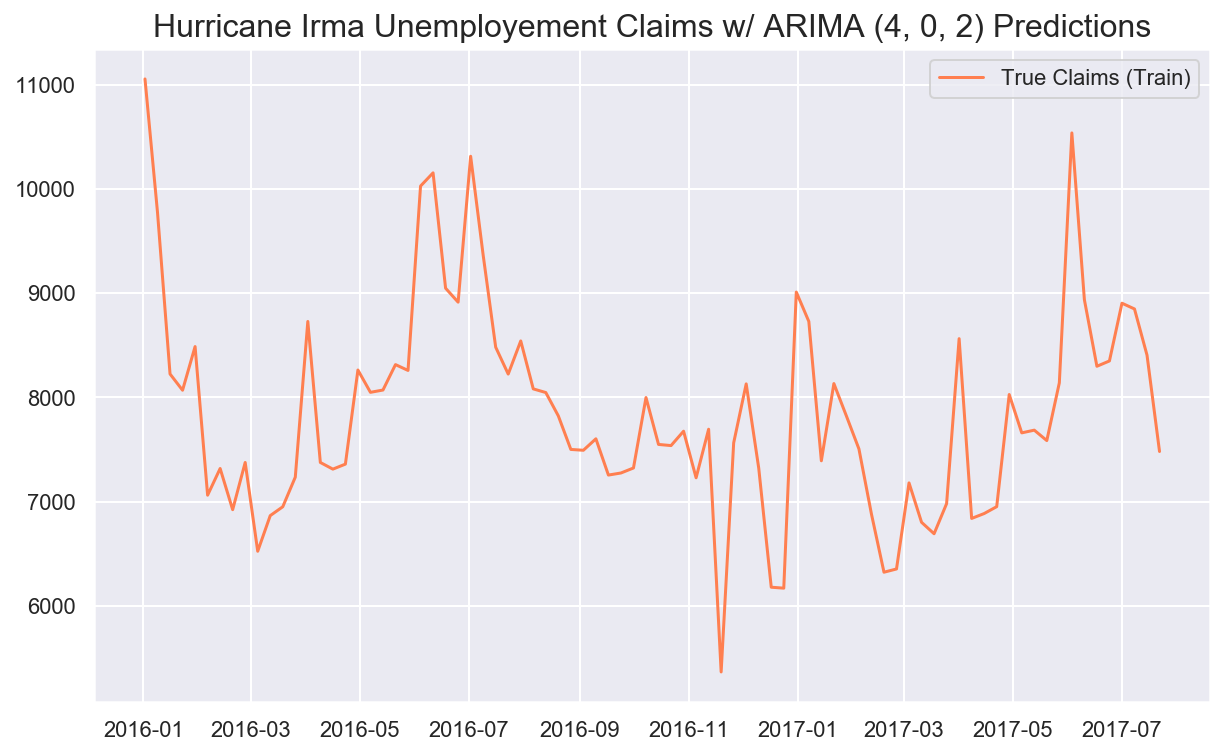

In [107]:
plt.figure(figsize=(10,6))
plt.title(label = f'Hurricane Irma Unemployement Claims w/ ARIMA ({4}, {0}, {2}) Predictions', fontsize=16);
sns.lineplot(data=train['Initial Claims'], color="coral", label="True Claims (Train)")
#sns.lineplot(data=qwi_LA_county_test['FrmJbLsS'], color="seagreen", label="Average Job Loss (Test)")
sns.lineplot(x = test.index, y = preds.values, color = 'seagreen', label="Predicted Claims")

In [108]:
df2 = pd.DataFrame(np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]),
                   columns=['category (1-5)', 
                            'duration (days)', 
                            'working population affected',
                            'avg wage',
                            'delta unemployment claims'])

df2

,category (1-5),duration (days),working population affected,avg wage,delta unemployment claims
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


1. hurricane name

2. hurricane category

3. states hit by hurricane and that experienced job lost (this one is complicated and will require lots of estimation)

4. total workforce population affected across all states

5. average wage of that population affected

## Calculate delta unemployment claims for all hurricanes

In [109]:
name = []
category = []
duration = []
working_pop = []
avg_wage = []
unemp_claims = []

## Irma

hurricane times: 6 weeks, 9/09/17 - 10/14/17

6 weeks before: 7/29/17 - 9/02/17

In [110]:
fl.index[-119]

Timestamp('2017-10-21 00:00:00')

In [111]:
start_row = fl.shape[0] - 140
stop_row = fl.shape[0] -119 #make sure its 1 plus the actual

before = fl.iloc[start_row:(stop_row - 6)]
after = fl.iloc[(before.shape[0]+start_row):stop_row]

before_claims_irma = before['Initial Claims'].mean() * after.shape[0]
after_claims_irma = after['Initial Claims'].sum()

In [112]:
duration_irma = 15 #DAYS
category_irma = 5
pop_irma = 140927392
wage_irma = 24

#### update columns

In [113]:
name.append('Irma')
category.append(category_irma)
duration.append(duration_irma)
working_pop.append(pop_irma)
avg_wage.append(wage_irma)
unemp_claims.append(after_claims_irma - before_claims_irma)

## Harvey

In [114]:
tx.shape

(522, 7)

In [115]:
tx.index[-118]

Timestamp('2017-09-23 00:00:00')

In [116]:
start_row = tx.shape[0] - 118 - 4 - 15
stop_row = tx.shape[0] - 117 #make sure its 1 plus the actual

before = tx.iloc[start_row:(stop_row - 5)]
after = tx.iloc[(before.shape[0]+start_row):stop_row]

before_claims_harvey = before['Initial Claims'].mean() * after.shape[0]
after_claims_harvey = after['Initial Claims'].sum()

In [117]:
duration_harvey = 4 #DAYS
category_harvey = 4
pop_harvey = 13758050
wage_harvey = 29

In [118]:
name.append('Harvey')
category.append(category_harvey)
duration.append(duration_harvey)
working_pop.append(pop_harvey)
avg_wage.append(wage_harvey)
unemp_claims.append(after_claims_harvey - before_claims_harvey)

### Make DF and Train, Test, Split

In [125]:
hurricanes = {'name': name, 
              'category': category,
              'duration': duration,
              'working_pop': working_pop,
              'avg_wage': avg_wage,
              'unemp_claim_delta': unemp_claims}

In [127]:
canes = pd.DataFrame(hurricanes)

In [128]:
X

name                      Irma
category                     5
duration                    15
working_pop          140927392
avg_wage                    24
unemp_claim_delta      30509.2
Name: 0, dtype: object

In [120]:
#hurricanes = 
pd.DataFrame(data = [name, category, duration, working_pop, avg_wage, unemp_claims], 
             columns=['name, category', 'duration', 'working_pop', 'avg_wage', 'unemp_claim_delta'])

ValueError: 5 columns passed, passed data had 2 columns

In [22]:
fl.index[-213]

Timestamp('2016-01-02 00:00:00')

In [26]:
# claim entry 5 weeks before the hurricane claim spike starts
#fl.index[-126]
fl.index[-131]

Timestamp('2017-09-02 00:00:00')

In [27]:
fl.index[-115]

Timestamp('2017-11-18 00:00:00')

In [28]:
# train_start_row = fl.shape[0] - 213
# train_stop_row = fl.shape[0] - 131
# test_stop_row = fl.shape[0] - 115

# train = fl.iloc[train_start_row:train_stop_row]
# test = fl.iloc[train_stop_row:test_stop_row]

In [55]:
train_start_row = fl.shape[0] - 213
train_stop_row = fl.shape[0] - 131
test_stop_row = fl.shape[0] - 115

train = fl.iloc[train_start_row:train_stop_row]
test = fl.iloc[train_stop_row:test_stop_row]